In [1]:
import sys
import os 


sys.path.append("../")
print(sys.path)


['/p300s/wangmx_group/xutingfeng/project_development/mmodel/pipline', '/p300s/wangmx_group/xutingfeng/SIS', '/p300s/wangmx_group/xutingfeng/statistic/proture', '/p300s/wangmx_group/xutingfeng/project_development/mmodel/pipline', '/xtdisk/xueyb_group/xutingfeng/Anaconda/envs/torch/lib/python310.zip', '/xtdisk/xueyb_group/xutingfeng/Anaconda/envs/torch/lib/python3.10', '/xtdisk/xueyb_group/xutingfeng/Anaconda/envs/torch/lib/python3.10/lib-dynload', '', '/xtdisk/xueyb_group/xutingfeng/Anaconda/envs/torch/lib/python3.10/site-packages', '/xtdisk/xueyb_group/xutingfeng/Anaconda/envs/torch/lib/python3.10/site-packages/PyYAML-6.0-py3.10-linux-x86_64.egg', '/xtdisk/xueyb_group/xutingfeng/Anaconda/envs/torch/lib/python3.10/site-packages/huggingface_hub-0.8.1-py3.8.egg', '/xtdisk/xueyb_group/xutingfeng/Anaconda/envs/torch/lib/python3.10/site-packages/sacremoses-0.0.43-py3.8.egg', '../']


In [2]:
import torch 
import pandas as pd 
from tqdm import tqdm
import pickle
from mmodel.dataloader import get_dataloader


    


 

## 读取数据集

In [3]:
dataname="dataset"  # 数据集需要保存在../data/dataname.csv

In [4]:
from mmodel.utils import csv_to_fusion_embedding, ensure_dirs
# from bio_embeddings.embed import ESM1bEmbedder

# embedder = ESM1bEmbedder()
# csv_to_fusion_embedding(csv_path, embedder, seq_col=["SLF_seq", "RNase_seq"], name_col="name", savedir="../data/esm_data/")

In [5]:
#预先计算各个组合之间的距离


# from mmodel.distance import compute_emb_distance
# compute_emb_distance(dataname)

In [6]:
#读取标签数据
from mmodel.utils import get_label_name_dict
label_name_dict = get_label_name_dict(f"../data/{dataname}.csv")

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.float32


In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.float32
print('device used:', device, '| dtype used: ',
          dtype,)

device used: cuda:0 | dtype used:  torch.float32


In [8]:
esm_emb = pickle.load(
    open('../data/distance_map/' +  dataname+ '_emb.pkl',
            'rb')).to(device=device, dtype=dtype)
dist_map = pickle.load(open('../data/distance_map/' + \
    dataname + '.pkl', 'rb')) 

In [9]:
esm_emb.shape

torch.Size([37, 1280])

In [10]:
from mmodel.utils import get_name_label_dict
name_label_dict = get_name_label_dict(label_name_dict)
name_label_dict

{'S11-SLF1_S7-RNase': [0],
 'S11-SLF2_S17-RNase': [0],
 'S9-SLF1_S5-RNase': [0],
 'S11-SLF2_S5-RNase': [0],
 'S11-SLF1_S5-RNase': [0],
 'S5-SLF1_S7-RNase': [0],
 'S9-SLF1_S7-RNase': [0],
 'S11-SLF1_S9-RNase': [0],
 'S11-SLF2_S7-RNase': [0],
 'S11-SLF3_S17-RNase': [0],
 'S7-SLF1_S5-RNase': [0],
 'S7-SLF1_S11-RNase': [0],
 'S7-SLF2_S5-RNase': [0],
 'S5-SLF2_S17-RNase': [0],
 'S5-SLF2_S7-RNase': [0],
 'S7-SLF3_S11-RNase': [0],
 'S7-SLF3_S17-RNase': [0],
 'S9-SLF1_S11-RNase': [0],
 'S11-SLF3_S5-RNase': [0],
 'S7-SLF2_S17-RNase': [0],
 'S7-SLF3_S9-RNase': [0],
 'S11-SLF3_S9-RNase': [0],
 'S5-SLF1_S11-RNase': [0],
 'S7-SLF3_S5-RNase': [0],
 'S11-SLF2_S9-RNase': [1],
 'S9-SLF1_S3-RNase': [1],
 'S11-SLF1_S17-RNase': [1],
 'S5-SLF1_S9-RNase': [1],
 'S7-SLF1_S9-RNase': [1],
 'S11-SLF3_S7-RNase': [1],
 'S7-SLF1_S17-RNase': [1],
 'S5-SLF2_S11-RNase': [1],
 'S7-SLF2_S9-RNase': [1],
 'S9-SLF1_S17-RNase': [1],
 'S5-SLF2_S9-RNase': [1],
 'S7-SLF2_S11-RNase': [1],
 'S5-SLF1_S17-RNase': [1]}

In [11]:
dataloader = get_dataloader(dist_map, label_name_dict, name_label_dict, knn=3, params={"batch_size": 4, "shuffle": True, "num_workers": 4})

In [12]:
from mmodel.model import LayerNormNet
import torch.nn as nn 
from mmodel.distance import get_dist_map

In [13]:
model = LayerNormNet(512, 128, device, dtype)
optimizer = torch.optim.NAdam(model.parameters(), lr=5e-4, betas=(0.9, 0.999))
criterion = nn.TripletMarginLoss(margin=1, reduction='mean')
best_loss = float('inf')
# train_loader = get_dataloader(dist_map, label_name_dict, name_label_dict, knn=1, params={"batch_size": 4, "shuffle": True, "num_workers": 4})

In [14]:
import time
def train(model, epoch, train_loader, optimizer,device, dtype, criterion, verbose=True):
    model.train()
    total_loss = 0
    start_time = time.time()
    for batch, x in enumerate(train_loader):
        data = x["data"]
        optimizer.zero_grad()
        anchor, positive, negative = data

        anchor_out = model(anchor.to(device=device, dtype=dtype))
        positive_out = model(positive.to(device=device, dtype=dtype))
        negative_out = model(negative.to(device=device, dtype=dtype))

        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if verbose:
            # lr = args.learning_rate
            ms_per_batch = (time.time() - start_time) * 1000
            cur_loss = total_loss 
            print(f'| epoch {epoch:3d} | {batch:5d}/{len(train_loader):5d} batches | '
                  f'ms/batch {ms_per_batch:6.4f} | '
                  f'loss {cur_loss:5.2f}')
            start_time = time.time()

    return total_loss/(batch + 1)

In [38]:


for x in train_loader:
    data = x["data"]
    anchor, positive, negative = data
    model.eval()
    print(x["label"])
    print(x["name"])
    anchor_out = model(anchor.to(device=device, dtype=dtype))
    positive_out = model(positive.to(device=device, dtype=dtype))
    negative_out = model(negative.to(device=device, dtype=dtype))

    loss = criterion(anchor_out, positive_out, negative_out)

    break 

[[tensor([0, 1, 1, 0])], [tensor([0, 1, 1, 0])], [tensor([1, 0, 0, 1])]]
[('S11-SLF2_S17-RNase', 'S5-SLF2_S9-RNase', 'S7-SLF1_S9-RNase', 'S11-SLF2_S5-RNase'), ('S9-SLF1_S11-RNase', 'S11-SLF1_S17-RNase', 'S11-SLF3_S7-RNase', 'S7-SLF3_S9-RNase'), ('S11-SLF2_S9-RNase', 'S11-SLF2_S17-RNase', 'S5-SLF1_S7-RNase', 'S11-SLF1_S17-RNase')]


In [45]:
dist_map[x["name"][0][1]]

{'S11-SLF1_S7-RNase': 3.2907078,
 'S11-SLF2_S17-RNase': 3.6872845,
 'S9-SLF1_S5-RNase': 2.74231,
 'S11-SLF2_S5-RNase': 3.9431725,
 'S11-SLF1_S5-RNase': 3.2801723,
 'S5-SLF1_S7-RNase': 3.450512,
 'S9-SLF1_S7-RNase': 3.3924286,
 'S11-SLF1_S9-RNase': 3.0447829,
 'S11-SLF2_S7-RNase': 3.3185222,
 'S11-SLF3_S17-RNase': 3.1505983,
 'S7-SLF1_S5-RNase': 2.6660569,
 'S7-SLF1_S11-RNase': 3.179361,
 'S7-SLF2_S5-RNase': 2.6084452,
 'S5-SLF2_S17-RNase': 2.9489636,
 'S5-SLF2_S7-RNase': 3.5364053,
 'S7-SLF3_S11-RNase': 3.560056,
 'S7-SLF3_S17-RNase': 3.2211049,
 'S9-SLF1_S11-RNase': 3.2781267,
 'S11-SLF3_S5-RNase': 3.9077432,
 'S7-SLF2_S17-RNase': 4.577488,
 'S7-SLF3_S9-RNase': 2.891596,
 'S11-SLF3_S9-RNase': 3.543517,
 'S5-SLF1_S11-RNase': 3.4332876,
 'S7-SLF3_S5-RNase': 3.346898,
 'S11-SLF2_S9-RNase': 3.4710257,
 'S9-SLF1_S3-RNase': 3.0483882,
 'S11-SLF1_S17-RNase': 3.23649,
 'S5-SLF1_S9-RNase': 3.1927392,
 'S7-SLF1_S9-RNase': 3.4641724,
 'S11-SLF3_S7-RNase': 2.8141613,
 'S7-SLF1_S17-RNase': 3.52259

In [16]:
for x in train_loader:
    print(x["data"])
    data =x["data"]
    anchor, positive, negative = data
    print(len(anchor))
    print(x["label"])
    break 

[tensor([[-0.1084,  0.3086, -0.0951,  ...,  0.0418, -0.0823,  0.0501],
        [-0.1119,  0.3013, -0.1301,  ...,  0.0394, -0.0765,  0.0421],
        [-0.1233,  0.3232, -0.0857,  ...,  0.0340, -0.0907,  0.0539],
        [-0.1089,  0.3007, -0.1211,  ...,  0.0341, -0.0746,  0.0534]]), tensor([[-0.1053,  0.2981, -0.1212,  ...,  0.0313, -0.0781,  0.0441],
        [-0.0995,  0.2917, -0.1288,  ...,  0.0289, -0.0824,  0.0536],
        [-0.1152,  0.3080, -0.1147,  ...,  0.0382, -0.0749,  0.0487],
        [-0.1026,  0.2923, -0.1379,  ...,  0.0342, -0.0842,  0.0424]]), tensor([[-0.1119,  0.3013, -0.1301,  ...,  0.0394, -0.0765,  0.0421],
        [-0.1089,  0.3007, -0.1211,  ...,  0.0341, -0.0746,  0.0534],
        [-0.1225,  0.3040, -0.1189,  ...,  0.0414, -0.0863,  0.0425],
        [-0.1113,  0.3004, -0.1306,  ...,  0.0397, -0.0773,  0.0444]])]
4
[[tensor([0, 1, 0, 0])], [tensor([0, 1, 0, 0])], [tensor([1, 0, 1, 1])]]


In [63]:
from tqdm import tqdm 
epochs = 400
for epoch in tqdm(range(1, epochs+1)):
    epoch_start_time = time.time()

    train_loss = train(model, 1, train_loader, optimizer, device, dtype, criterion, verbose=False)
    
    dist_map = get_dist_map(label_name_dict, esm_emb, device, dtype,model=model)
    train_loader = get_dataloader(dist_map, label_name_dict, name_label_dict, knn=8, params={"batch_size": 4, "shuffle": True, "num_workers": 4})

    elapsed = time.time() - epoch_start_time
    if epoch % 1 == 0:
        print('-' * 75)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
                f'training loss {train_loss:6.4f}')
        print('-' * 75)
        # break 
        torch.save(model.state_dict(), '../data/model/' + f"{epoch}" + '.pth')

  0%|          | 1/400 [00:00<03:09,  2.11it/s]

---------------------------------------------------------------------------
| end of epoch   1 | time:  0.45s | training loss 1.0199
---------------------------------------------------------------------------


  0%|          | 2/400 [00:01<03:30,  1.89it/s]

---------------------------------------------------------------------------
| end of epoch   2 | time:  0.53s | training loss 0.9788
---------------------------------------------------------------------------


  1%|          | 3/400 [00:01<03:43,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch   3 | time:  0.58s | training loss 1.0797
---------------------------------------------------------------------------


  1%|          | 4/400 [00:02<03:45,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch   4 | time:  0.55s | training loss 0.9998
---------------------------------------------------------------------------


  1%|▏         | 5/400 [00:02<03:41,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch   5 | time:  0.51s | training loss 0.9693
---------------------------------------------------------------------------


  2%|▏         | 6/400 [00:03<03:39,  1.80it/s]

---------------------------------------------------------------------------
| end of epoch   6 | time:  0.51s | training loss 0.9567
---------------------------------------------------------------------------


  2%|▏         | 7/400 [00:03<03:37,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch   7 | time:  0.51s | training loss 0.8763
---------------------------------------------------------------------------


  2%|▏         | 8/400 [00:04<03:33,  1.84it/s]

---------------------------------------------------------------------------
| end of epoch   8 | time:  0.49s | training loss 0.9516
---------------------------------------------------------------------------


  2%|▏         | 9/400 [00:04<03:26,  1.89it/s]

---------------------------------------------------------------------------
| end of epoch   9 | time:  0.47s | training loss 1.1854
---------------------------------------------------------------------------


  2%|▎         | 10/400 [00:05<03:32,  1.83it/s]

---------------------------------------------------------------------------
| end of epoch  10 | time:  0.55s | training loss 1.1638
---------------------------------------------------------------------------


  3%|▎         | 11/400 [00:06<03:30,  1.84it/s]

---------------------------------------------------------------------------
| end of epoch  11 | time:  0.51s | training loss 1.0804
---------------------------------------------------------------------------


  3%|▎         | 12/400 [00:06<03:34,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch  12 | time:  0.55s | training loss 0.8276
---------------------------------------------------------------------------


  3%|▎         | 13/400 [00:07<03:28,  1.86it/s]

---------------------------------------------------------------------------
| end of epoch  13 | time:  0.47s | training loss 1.0171
---------------------------------------------------------------------------


  4%|▎         | 14/400 [00:07<03:43,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch  14 | time:  0.63s | training loss 0.9335
---------------------------------------------------------------------------


  4%|▍         | 15/400 [00:08<03:43,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch  15 | time:  0.54s | training loss 0.9994
---------------------------------------------------------------------------


  4%|▍         | 16/400 [00:08<03:48,  1.68it/s]

---------------------------------------------------------------------------
| end of epoch  16 | time:  0.60s | training loss 0.9462
---------------------------------------------------------------------------


  4%|▍         | 17/400 [00:09<03:52,  1.65it/s]

---------------------------------------------------------------------------
| end of epoch  17 | time:  0.61s | training loss 0.9550
---------------------------------------------------------------------------


  4%|▍         | 18/400 [00:10<03:43,  1.71it/s]

---------------------------------------------------------------------------
| end of epoch  18 | time:  0.50s | training loss 0.9930
---------------------------------------------------------------------------


  5%|▍         | 19/400 [00:10<03:58,  1.60it/s]

---------------------------------------------------------------------------
| end of epoch  19 | time:  0.68s | training loss 0.9384
---------------------------------------------------------------------------


  5%|▌         | 20/400 [00:11<03:51,  1.64it/s]

---------------------------------------------------------------------------
| end of epoch  20 | time:  0.54s | training loss 1.1203
---------------------------------------------------------------------------


  5%|▌         | 21/400 [00:11<03:41,  1.71it/s]

---------------------------------------------------------------------------
| end of epoch  21 | time:  0.50s | training loss 0.9781
---------------------------------------------------------------------------


  6%|▌         | 22/400 [00:12<03:44,  1.69it/s]

---------------------------------------------------------------------------
| end of epoch  22 | time:  0.57s | training loss 1.0152
---------------------------------------------------------------------------


  6%|▌         | 23/400 [00:13<03:34,  1.76it/s]

---------------------------------------------------------------------------
| end of epoch  23 | time:  0.48s | training loss 0.9540
---------------------------------------------------------------------------


  6%|▌         | 24/400 [00:13<03:25,  1.83it/s]

---------------------------------------------------------------------------
| end of epoch  24 | time:  0.47s | training loss 1.0267
---------------------------------------------------------------------------


  6%|▋         | 25/400 [00:14<03:45,  1.67it/s]

---------------------------------------------------------------------------
| end of epoch  25 | time:  0.69s | training loss 0.9582
---------------------------------------------------------------------------


  6%|▋         | 26/400 [00:14<03:47,  1.64it/s]

---------------------------------------------------------------------------
| end of epoch  26 | time:  0.60s | training loss 1.1048
---------------------------------------------------------------------------


  7%|▋         | 27/400 [00:15<03:47,  1.64it/s]

---------------------------------------------------------------------------
| end of epoch  27 | time:  0.58s | training loss 1.0706
---------------------------------------------------------------------------


  7%|▋         | 28/400 [00:16<03:58,  1.56it/s]

---------------------------------------------------------------------------
| end of epoch  28 | time:  0.68s | training loss 1.2431
---------------------------------------------------------------------------


  7%|▋         | 29/400 [00:16<03:43,  1.66it/s]

---------------------------------------------------------------------------
| end of epoch  29 | time:  0.49s | training loss 1.0374
---------------------------------------------------------------------------


  8%|▊         | 30/400 [00:17<03:36,  1.71it/s]

---------------------------------------------------------------------------
| end of epoch  30 | time:  0.51s | training loss 0.9777
---------------------------------------------------------------------------


  8%|▊         | 31/400 [00:17<03:33,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch  31 | time:  0.53s | training loss 0.9803
---------------------------------------------------------------------------


  8%|▊         | 32/400 [00:18<03:35,  1.71it/s]

---------------------------------------------------------------------------
| end of epoch  32 | time:  0.57s | training loss 1.0846
---------------------------------------------------------------------------


  8%|▊         | 33/400 [00:19<03:42,  1.65it/s]

---------------------------------------------------------------------------
| end of epoch  33 | time:  0.61s | training loss 1.0227
---------------------------------------------------------------------------


  8%|▊         | 34/400 [00:19<03:40,  1.66it/s]

---------------------------------------------------------------------------
| end of epoch  34 | time:  0.57s | training loss 0.9586
---------------------------------------------------------------------------


  9%|▉         | 35/400 [00:20<03:38,  1.67it/s]

---------------------------------------------------------------------------
| end of epoch  35 | time:  0.55s | training loss 1.0827
---------------------------------------------------------------------------


  9%|▉         | 36/400 [00:20<03:28,  1.74it/s]

---------------------------------------------------------------------------
| end of epoch  36 | time:  0.49s | training loss 0.9739
---------------------------------------------------------------------------


  9%|▉         | 37/400 [00:21<03:26,  1.76it/s]

---------------------------------------------------------------------------
| end of epoch  37 | time:  0.53s | training loss 0.9587
---------------------------------------------------------------------------


 10%|▉         | 38/400 [00:21<03:22,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch  38 | time:  0.51s | training loss 1.0146
---------------------------------------------------------------------------


 10%|▉         | 39/400 [00:22<03:47,  1.59it/s]

---------------------------------------------------------------------------
| end of epoch  39 | time:  0.76s | training loss 1.0167
---------------------------------------------------------------------------


 10%|█         | 40/400 [00:23<03:40,  1.63it/s]

---------------------------------------------------------------------------
| end of epoch  40 | time:  0.54s | training loss 0.9160
---------------------------------------------------------------------------


 10%|█         | 41/400 [00:23<03:25,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch  41 | time:  0.46s | training loss 1.1324
---------------------------------------------------------------------------


 10%|█         | 42/400 [00:24<03:20,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch  42 | time:  0.50s | training loss 1.0808
---------------------------------------------------------------------------


 11%|█         | 43/400 [00:24<03:17,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch  43 | time:  0.51s | training loss 0.9959
---------------------------------------------------------------------------


 11%|█         | 44/400 [00:25<03:16,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch  44 | time:  0.52s | training loss 1.1461
---------------------------------------------------------------------------


 11%|█▏        | 45/400 [00:25<03:17,  1.79it/s]

---------------------------------------------------------------------------
| end of epoch  45 | time:  0.53s | training loss 1.0674
---------------------------------------------------------------------------


 12%|█▏        | 46/400 [00:26<03:21,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch  46 | time:  0.56s | training loss 1.0150
---------------------------------------------------------------------------


 12%|█▏        | 47/400 [00:27<03:21,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch  47 | time:  0.54s | training loss 1.0483
---------------------------------------------------------------------------


 12%|█▏        | 48/400 [00:27<03:19,  1.76it/s]

---------------------------------------------------------------------------
| end of epoch  48 | time:  0.52s | training loss 0.8508
---------------------------------------------------------------------------


 12%|█▏        | 49/400 [00:28<03:11,  1.83it/s]

---------------------------------------------------------------------------
| end of epoch  49 | time:  0.47s | training loss 0.9741
---------------------------------------------------------------------------


 12%|█▎        | 50/400 [00:28<03:13,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch  50 | time:  0.53s | training loss 1.0668
---------------------------------------------------------------------------


 13%|█▎        | 51/400 [00:29<03:20,  1.74it/s]

---------------------------------------------------------------------------
| end of epoch  51 | time:  0.59s | training loss 1.0481
---------------------------------------------------------------------------


 13%|█▎        | 52/400 [00:29<03:16,  1.77it/s]

---------------------------------------------------------------------------
| end of epoch  52 | time:  0.51s | training loss 0.9035
---------------------------------------------------------------------------


 13%|█▎        | 53/400 [00:30<03:16,  1.77it/s]

---------------------------------------------------------------------------
| end of epoch  53 | time:  0.53s | training loss 0.8615
---------------------------------------------------------------------------


 14%|█▎        | 54/400 [00:31<03:18,  1.74it/s]

---------------------------------------------------------------------------
| end of epoch  54 | time:  0.56s | training loss 0.8524
---------------------------------------------------------------------------


 14%|█▍        | 55/400 [00:31<03:15,  1.77it/s]

---------------------------------------------------------------------------
| end of epoch  55 | time:  0.51s | training loss 0.8372
---------------------------------------------------------------------------


 14%|█▍        | 56/400 [00:32<03:14,  1.77it/s]

---------------------------------------------------------------------------
| end of epoch  56 | time:  0.54s | training loss 0.9350
---------------------------------------------------------------------------


 14%|█▍        | 57/400 [00:32<03:17,  1.74it/s]

---------------------------------------------------------------------------
| end of epoch  57 | time:  0.56s | training loss 1.0948
---------------------------------------------------------------------------


 14%|█▍        | 58/400 [00:33<03:17,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch  58 | time:  0.55s | training loss 0.9939
---------------------------------------------------------------------------


 15%|█▍        | 59/400 [00:33<03:20,  1.70it/s]

---------------------------------------------------------------------------
| end of epoch  59 | time:  0.57s | training loss 1.0468
---------------------------------------------------------------------------


 15%|█▌        | 60/400 [00:34<03:24,  1.66it/s]

---------------------------------------------------------------------------
| end of epoch  60 | time:  0.61s | training loss 0.9777
---------------------------------------------------------------------------


 15%|█▌        | 61/400 [00:35<03:28,  1.63it/s]

---------------------------------------------------------------------------
| end of epoch  61 | time:  0.60s | training loss 1.0691
---------------------------------------------------------------------------


 16%|█▌        | 62/400 [00:36<03:41,  1.53it/s]

---------------------------------------------------------------------------
| end of epoch  62 | time:  0.71s | training loss 0.9583
---------------------------------------------------------------------------


 16%|█▌        | 63/400 [00:36<03:26,  1.63it/s]

---------------------------------------------------------------------------
| end of epoch  63 | time:  0.48s | training loss 1.0183
---------------------------------------------------------------------------


 16%|█▌        | 64/400 [00:37<03:15,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch  64 | time:  0.49s | training loss 1.0487
---------------------------------------------------------------------------


 16%|█▋        | 65/400 [00:37<03:08,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch  65 | time:  0.49s | training loss 0.9706
---------------------------------------------------------------------------


 16%|█▋        | 66/400 [00:38<03:04,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch  66 | time:  0.49s | training loss 1.0788
---------------------------------------------------------------------------


 17%|█▋        | 67/400 [00:38<03:14,  1.71it/s]

---------------------------------------------------------------------------
| end of epoch  67 | time:  0.62s | training loss 1.0452
---------------------------------------------------------------------------


 17%|█▋        | 68/400 [00:39<03:11,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch  68 | time:  0.52s | training loss 0.8960
---------------------------------------------------------------------------


 17%|█▋        | 69/400 [00:39<03:14,  1.70it/s]

---------------------------------------------------------------------------
| end of epoch  69 | time:  0.58s | training loss 0.9843
---------------------------------------------------------------------------


 18%|█▊        | 70/400 [00:40<03:17,  1.67it/s]

---------------------------------------------------------------------------
| end of epoch  70 | time:  0.59s | training loss 1.1238
---------------------------------------------------------------------------


 18%|█▊        | 71/400 [00:41<03:16,  1.68it/s]

---------------------------------------------------------------------------
| end of epoch  71 | time:  0.55s | training loss 1.0347
---------------------------------------------------------------------------


 18%|█▊        | 72/400 [00:41<03:10,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch  72 | time:  0.51s | training loss 1.0876
---------------------------------------------------------------------------


 18%|█▊        | 73/400 [00:42<03:15,  1.67it/s]

---------------------------------------------------------------------------
| end of epoch  73 | time:  0.59s | training loss 0.9207
---------------------------------------------------------------------------


 18%|█▊        | 74/400 [00:43<03:27,  1.57it/s]

---------------------------------------------------------------------------
| end of epoch  74 | time:  0.69s | training loss 0.9880
---------------------------------------------------------------------------


 19%|█▉        | 75/400 [00:43<03:34,  1.51it/s]

---------------------------------------------------------------------------
| end of epoch  75 | time:  0.68s | training loss 0.9636
---------------------------------------------------------------------------


 19%|█▉        | 76/400 [00:44<03:19,  1.62it/s]

---------------------------------------------------------------------------
| end of epoch  76 | time:  0.48s | training loss 1.0377
---------------------------------------------------------------------------


 19%|█▉        | 77/400 [00:44<03:08,  1.71it/s]

---------------------------------------------------------------------------
| end of epoch  77 | time:  0.48s | training loss 0.6436
---------------------------------------------------------------------------


 20%|█▉        | 78/400 [00:45<03:10,  1.69it/s]

---------------------------------------------------------------------------
| end of epoch  78 | time:  0.57s | training loss 1.1273
---------------------------------------------------------------------------


 20%|█▉        | 79/400 [00:46<03:12,  1.66it/s]

---------------------------------------------------------------------------
| end of epoch  79 | time:  0.58s | training loss 0.9924
---------------------------------------------------------------------------


 20%|██        | 80/400 [00:46<03:08,  1.70it/s]

---------------------------------------------------------------------------
| end of epoch  80 | time:  0.53s | training loss 0.9828
---------------------------------------------------------------------------


 20%|██        | 81/400 [00:47<03:03,  1.74it/s]

---------------------------------------------------------------------------
| end of epoch  81 | time:  0.51s | training loss 1.1791
---------------------------------------------------------------------------


 20%|██        | 82/400 [00:47<03:02,  1.74it/s]

---------------------------------------------------------------------------
| end of epoch  82 | time:  0.54s | training loss 0.9563
---------------------------------------------------------------------------


 21%|██        | 83/400 [00:48<03:07,  1.69it/s]

---------------------------------------------------------------------------
| end of epoch  83 | time:  0.59s | training loss 1.0534
---------------------------------------------------------------------------


 21%|██        | 84/400 [00:48<03:06,  1.69it/s]

---------------------------------------------------------------------------
| end of epoch  84 | time:  0.55s | training loss 1.1454
---------------------------------------------------------------------------


 21%|██▏       | 85/400 [00:49<03:09,  1.67it/s]

---------------------------------------------------------------------------
| end of epoch  85 | time:  0.58s | training loss 1.0063
---------------------------------------------------------------------------


 22%|██▏       | 86/400 [00:50<03:09,  1.66it/s]

---------------------------------------------------------------------------
| end of epoch  86 | time:  0.57s | training loss 1.0649
---------------------------------------------------------------------------


 22%|██▏       | 87/400 [00:50<03:16,  1.59it/s]

---------------------------------------------------------------------------
| end of epoch  87 | time:  0.64s | training loss 0.8522
---------------------------------------------------------------------------


 22%|██▏       | 88/400 [00:51<03:23,  1.53it/s]

---------------------------------------------------------------------------
| end of epoch  88 | time:  0.68s | training loss 0.8886
---------------------------------------------------------------------------


 22%|██▏       | 89/400 [00:52<03:15,  1.59it/s]

---------------------------------------------------------------------------
| end of epoch  89 | time:  0.53s | training loss 1.0062
---------------------------------------------------------------------------


 22%|██▎       | 90/400 [00:52<03:09,  1.63it/s]

---------------------------------------------------------------------------
| end of epoch  90 | time:  0.52s | training loss 1.0411
---------------------------------------------------------------------------


 23%|██▎       | 91/400 [00:53<03:03,  1.68it/s]

---------------------------------------------------------------------------
| end of epoch  91 | time:  0.52s | training loss 1.1030
---------------------------------------------------------------------------


 23%|██▎       | 92/400 [00:53<02:58,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch  92 | time:  0.51s | training loss 0.9457
---------------------------------------------------------------------------


 23%|██▎       | 93/400 [00:54<02:58,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch  93 | time:  0.55s | training loss 0.7590
---------------------------------------------------------------------------


 24%|██▎       | 94/400 [00:54<02:55,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch  94 | time:  0.52s | training loss 1.0413
---------------------------------------------------------------------------


 24%|██▍       | 95/400 [00:55<02:59,  1.70it/s]

---------------------------------------------------------------------------
| end of epoch  95 | time:  0.59s | training loss 0.9125
---------------------------------------------------------------------------


 24%|██▍       | 96/400 [00:56<03:00,  1.69it/s]

---------------------------------------------------------------------------
| end of epoch  96 | time:  0.57s | training loss 0.9504
---------------------------------------------------------------------------


 24%|██▍       | 97/400 [00:56<02:55,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch  97 | time:  0.51s | training loss 0.9674
---------------------------------------------------------------------------


 24%|██▍       | 98/400 [00:57<02:54,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch  98 | time:  0.54s | training loss 1.0363
---------------------------------------------------------------------------


 25%|██▍       | 99/400 [00:57<02:53,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch  99 | time:  0.55s | training loss 1.0173
---------------------------------------------------------------------------


 25%|██▌       | 100/400 [00:58<02:45,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch 100 | time:  0.47s | training loss 1.0690
---------------------------------------------------------------------------


 25%|██▌       | 101/400 [00:58<02:49,  1.77it/s]

---------------------------------------------------------------------------
| end of epoch 101 | time:  0.56s | training loss 1.0010
---------------------------------------------------------------------------


 26%|██▌       | 102/400 [00:59<02:53,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch 102 | time:  0.57s | training loss 0.9366
---------------------------------------------------------------------------


 26%|██▌       | 103/400 [01:00<02:54,  1.71it/s]

---------------------------------------------------------------------------
| end of epoch 103 | time:  0.55s | training loss 1.0171
---------------------------------------------------------------------------


 26%|██▌       | 104/400 [01:00<02:47,  1.77it/s]

---------------------------------------------------------------------------
| end of epoch 104 | time:  0.49s | training loss 0.9724
---------------------------------------------------------------------------


 26%|██▋       | 105/400 [01:01<02:48,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch 105 | time:  0.55s | training loss 1.0204
---------------------------------------------------------------------------


 26%|██▋       | 106/400 [01:01<02:59,  1.64it/s]

---------------------------------------------------------------------------
| end of epoch 106 | time:  0.66s | training loss 1.0077
---------------------------------------------------------------------------


 27%|██▋       | 107/400 [01:02<02:56,  1.66it/s]

---------------------------------------------------------------------------
| end of epoch 107 | time:  0.54s | training loss 1.1051
---------------------------------------------------------------------------


 27%|██▋       | 108/400 [01:03<03:02,  1.60it/s]

---------------------------------------------------------------------------
| end of epoch 108 | time:  0.64s | training loss 1.0302
---------------------------------------------------------------------------


 27%|██▋       | 109/400 [01:03<02:56,  1.65it/s]

---------------------------------------------------------------------------
| end of epoch 109 | time:  0.53s | training loss 1.0108
---------------------------------------------------------------------------


 28%|██▊       | 110/400 [01:04<02:48,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch 110 | time:  0.49s | training loss 0.9083
---------------------------------------------------------------------------


 28%|██▊       | 111/400 [01:04<02:42,  1.77it/s]

---------------------------------------------------------------------------
| end of epoch 111 | time:  0.48s | training loss 1.0175
---------------------------------------------------------------------------


 28%|██▊       | 112/400 [01:05<02:50,  1.69it/s]

---------------------------------------------------------------------------
| end of epoch 112 | time:  0.62s | training loss 1.2370
---------------------------------------------------------------------------


 28%|██▊       | 113/400 [01:06<02:43,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch 113 | time:  0.49s | training loss 0.9760
---------------------------------------------------------------------------


 28%|██▊       | 114/400 [01:06<02:42,  1.76it/s]

---------------------------------------------------------------------------
| end of epoch 114 | time:  0.53s | training loss 0.8504
---------------------------------------------------------------------------


 29%|██▉       | 115/400 [01:07<02:43,  1.74it/s]

---------------------------------------------------------------------------
| end of epoch 115 | time:  0.55s | training loss 0.9727
---------------------------------------------------------------------------


 29%|██▉       | 116/400 [01:07<02:42,  1.74it/s]

---------------------------------------------------------------------------
| end of epoch 116 | time:  0.54s | training loss 0.9138
---------------------------------------------------------------------------


 29%|██▉       | 117/400 [01:08<02:42,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch 117 | time:  0.53s | training loss 0.8711
---------------------------------------------------------------------------


 30%|██▉       | 118/400 [01:08<02:36,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch 118 | time:  0.48s | training loss 1.0112
---------------------------------------------------------------------------


 30%|██▉       | 119/400 [01:09<02:40,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch 119 | time:  0.58s | training loss 0.8889
---------------------------------------------------------------------------


 30%|███       | 120/400 [01:10<02:43,  1.71it/s]

---------------------------------------------------------------------------
| end of epoch 120 | time:  0.58s | training loss 0.8931
---------------------------------------------------------------------------


 30%|███       | 121/400 [01:10<02:38,  1.76it/s]

---------------------------------------------------------------------------
| end of epoch 121 | time:  0.50s | training loss 1.0407
---------------------------------------------------------------------------


 30%|███       | 122/400 [01:11<02:40,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch 122 | time:  0.56s | training loss 1.0210
---------------------------------------------------------------------------


 31%|███       | 123/400 [01:11<02:38,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch 123 | time:  0.52s | training loss 0.8896
---------------------------------------------------------------------------


 31%|███       | 124/400 [01:12<02:38,  1.74it/s]

---------------------------------------------------------------------------
| end of epoch 124 | time:  0.54s | training loss 1.0434
---------------------------------------------------------------------------


 31%|███▏      | 125/400 [01:12<02:31,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch 125 | time:  0.47s | training loss 1.0942
---------------------------------------------------------------------------


 32%|███▏      | 126/400 [01:13<02:30,  1.82it/s]

---------------------------------------------------------------------------
| end of epoch 126 | time:  0.51s | training loss 1.1391
---------------------------------------------------------------------------


 32%|███▏      | 127/400 [01:13<02:35,  1.76it/s]

---------------------------------------------------------------------------
| end of epoch 127 | time:  0.58s | training loss 1.0892
---------------------------------------------------------------------------


 32%|███▏      | 128/400 [01:14<02:34,  1.76it/s]

---------------------------------------------------------------------------
| end of epoch 128 | time:  0.53s | training loss 1.1145
---------------------------------------------------------------------------


 32%|███▏      | 129/400 [01:15<02:37,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch 129 | time:  0.58s | training loss 0.9239
---------------------------------------------------------------------------


 32%|███▎      | 130/400 [01:15<02:34,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch 130 | time:  0.51s | training loss 1.0634
---------------------------------------------------------------------------


 33%|███▎      | 131/400 [01:16<02:32,  1.76it/s]

---------------------------------------------------------------------------
| end of epoch 131 | time:  0.52s | training loss 1.2407
---------------------------------------------------------------------------


 33%|███▎      | 132/400 [01:16<02:42,  1.65it/s]

---------------------------------------------------------------------------
| end of epoch 132 | time:  0.66s | training loss 1.1167
---------------------------------------------------------------------------


 33%|███▎      | 133/400 [01:17<02:49,  1.58it/s]

---------------------------------------------------------------------------
| end of epoch 133 | time:  0.66s | training loss 1.1200
---------------------------------------------------------------------------


 34%|███▎      | 134/400 [01:18<02:41,  1.64it/s]

---------------------------------------------------------------------------
| end of epoch 134 | time:  0.51s | training loss 0.8517
---------------------------------------------------------------------------


 34%|███▍      | 135/400 [01:18<02:33,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch 135 | time:  0.49s | training loss 1.0924
---------------------------------------------------------------------------


 34%|███▍      | 136/400 [01:19<02:32,  1.74it/s]

---------------------------------------------------------------------------
| end of epoch 136 | time:  0.53s | training loss 1.0849
---------------------------------------------------------------------------


 34%|███▍      | 137/400 [01:19<02:29,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch 137 | time:  0.52s | training loss 0.9965
---------------------------------------------------------------------------


 34%|███▍      | 138/400 [01:20<02:32,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch 138 | time:  0.57s | training loss 0.9048
---------------------------------------------------------------------------


 35%|███▍      | 139/400 [01:20<02:28,  1.76it/s]

---------------------------------------------------------------------------
| end of epoch 139 | time:  0.51s | training loss 1.0471
---------------------------------------------------------------------------


 35%|███▌      | 140/400 [01:21<02:30,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch 140 | time:  0.56s | training loss 0.8210
---------------------------------------------------------------------------


 35%|███▌      | 141/400 [01:22<02:30,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch 141 | time:  0.55s | training loss 1.1068
---------------------------------------------------------------------------


 36%|███▌      | 142/400 [01:22<02:35,  1.66it/s]

---------------------------------------------------------------------------
| end of epoch 142 | time:  0.62s | training loss 1.0993
---------------------------------------------------------------------------


 36%|███▌      | 143/400 [01:23<02:25,  1.76it/s]

---------------------------------------------------------------------------
| end of epoch 143 | time:  0.45s | training loss 1.0537
---------------------------------------------------------------------------


 36%|███▌      | 144/400 [01:23<02:25,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch 144 | time:  0.54s | training loss 0.9175
---------------------------------------------------------------------------


 36%|███▋      | 145/400 [01:24<02:27,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch 145 | time:  0.56s | training loss 0.7941
---------------------------------------------------------------------------


 36%|███▋      | 146/400 [01:25<02:22,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch 146 | time:  0.50s | training loss 1.0358
---------------------------------------------------------------------------


 37%|███▋      | 147/400 [01:25<02:19,  1.82it/s]

---------------------------------------------------------------------------
| end of epoch 147 | time:  0.49s | training loss 1.0479
---------------------------------------------------------------------------


 37%|███▋      | 148/400 [01:26<02:21,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch 148 | time:  0.55s | training loss 1.0990
---------------------------------------------------------------------------


 37%|███▋      | 149/400 [01:26<02:22,  1.77it/s]

---------------------------------------------------------------------------
| end of epoch 149 | time:  0.55s | training loss 1.0204
---------------------------------------------------------------------------


 38%|███▊      | 150/400 [01:27<02:18,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch 150 | time:  0.50s | training loss 0.9988
---------------------------------------------------------------------------


 38%|███▊      | 151/400 [01:27<02:13,  1.87it/s]

---------------------------------------------------------------------------
| end of epoch 151 | time:  0.46s | training loss 1.0581
---------------------------------------------------------------------------


 38%|███▊      | 152/400 [01:28<02:13,  1.86it/s]

---------------------------------------------------------------------------
| end of epoch 152 | time:  0.51s | training loss 1.0494
---------------------------------------------------------------------------


 38%|███▊      | 153/400 [01:28<02:14,  1.84it/s]

---------------------------------------------------------------------------
| end of epoch 153 | time:  0.52s | training loss 0.9338
---------------------------------------------------------------------------


 38%|███▊      | 154/400 [01:29<02:15,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch 154 | time:  0.53s | training loss 1.0903
---------------------------------------------------------------------------


 39%|███▉      | 155/400 [01:29<02:18,  1.77it/s]

---------------------------------------------------------------------------
| end of epoch 155 | time:  0.55s | training loss 0.9307
---------------------------------------------------------------------------


 39%|███▉      | 156/400 [01:30<02:21,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch 156 | time:  0.58s | training loss 1.1515
---------------------------------------------------------------------------


 39%|███▉      | 157/400 [01:31<02:16,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch 157 | time:  0.49s | training loss 1.0022
---------------------------------------------------------------------------


 40%|███▉      | 158/400 [01:31<02:25,  1.67it/s]

---------------------------------------------------------------------------
| end of epoch 158 | time:  0.66s | training loss 0.9435
---------------------------------------------------------------------------


 40%|███▉      | 159/400 [01:32<02:24,  1.67it/s]

---------------------------------------------------------------------------
| end of epoch 159 | time:  0.55s | training loss 0.9128
---------------------------------------------------------------------------


 40%|████      | 160/400 [01:33<02:33,  1.56it/s]

---------------------------------------------------------------------------
| end of epoch 160 | time:  0.70s | training loss 1.0178
---------------------------------------------------------------------------


 40%|████      | 161/400 [01:33<02:23,  1.67it/s]

---------------------------------------------------------------------------
| end of epoch 161 | time:  0.48s | training loss 1.1952
---------------------------------------------------------------------------


 40%|████      | 162/400 [01:34<02:13,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch 162 | time:  0.44s | training loss 1.0634
---------------------------------------------------------------------------


 41%|████      | 163/400 [01:34<02:09,  1.83it/s]

---------------------------------------------------------------------------
| end of epoch 163 | time:  0.47s | training loss 1.0314
---------------------------------------------------------------------------


 41%|████      | 164/400 [01:35<02:11,  1.79it/s]

---------------------------------------------------------------------------
| end of epoch 164 | time:  0.54s | training loss 0.9010
---------------------------------------------------------------------------


 41%|████▏     | 165/400 [01:35<02:12,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch 165 | time:  0.53s | training loss 0.9187
---------------------------------------------------------------------------


 42%|████▏     | 166/400 [01:36<02:11,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch 166 | time:  0.53s | training loss 0.8646
---------------------------------------------------------------------------


 42%|████▏     | 167/400 [01:36<02:06,  1.84it/s]

---------------------------------------------------------------------------
| end of epoch 167 | time:  0.47s | training loss 1.0567
---------------------------------------------------------------------------


 42%|████▏     | 168/400 [01:37<02:02,  1.90it/s]

---------------------------------------------------------------------------
| end of epoch 168 | time:  0.46s | training loss 1.1438
---------------------------------------------------------------------------


 42%|████▏     | 169/400 [01:37<02:00,  1.92it/s]

---------------------------------------------------------------------------
| end of epoch 169 | time:  0.47s | training loss 0.8489
---------------------------------------------------------------------------


 42%|████▎     | 170/400 [01:38<02:01,  1.89it/s]

---------------------------------------------------------------------------
| end of epoch 170 | time:  0.51s | training loss 1.1581
---------------------------------------------------------------------------


 43%|████▎     | 171/400 [01:38<02:01,  1.88it/s]

---------------------------------------------------------------------------
| end of epoch 171 | time:  0.50s | training loss 1.0867
---------------------------------------------------------------------------


 43%|████▎     | 172/400 [01:39<02:01,  1.88it/s]

---------------------------------------------------------------------------
| end of epoch 172 | time:  0.50s | training loss 1.0233
---------------------------------------------------------------------------


 43%|████▎     | 173/400 [01:40<02:03,  1.84it/s]

---------------------------------------------------------------------------
| end of epoch 173 | time:  0.53s | training loss 0.9945
---------------------------------------------------------------------------


 44%|████▎     | 174/400 [01:40<02:04,  1.82it/s]

---------------------------------------------------------------------------
| end of epoch 174 | time:  0.53s | training loss 1.0179
---------------------------------------------------------------------------


 44%|████▍     | 175/400 [01:41<02:09,  1.74it/s]

---------------------------------------------------------------------------
| end of epoch 175 | time:  0.61s | training loss 0.9098
---------------------------------------------------------------------------


 44%|████▍     | 176/400 [01:41<02:06,  1.77it/s]

---------------------------------------------------------------------------
| end of epoch 176 | time:  0.51s | training loss 1.0840
---------------------------------------------------------------------------


 44%|████▍     | 177/400 [01:42<02:05,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch 177 | time:  0.52s | training loss 1.0410
---------------------------------------------------------------------------


 44%|████▍     | 178/400 [01:42<02:02,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch 178 | time:  0.49s | training loss 0.9388
---------------------------------------------------------------------------


 45%|████▍     | 179/400 [01:43<02:04,  1.77it/s]

---------------------------------------------------------------------------
| end of epoch 179 | time:  0.56s | training loss 1.2283
---------------------------------------------------------------------------


 45%|████▌     | 180/400 [01:44<02:06,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch 180 | time:  0.57s | training loss 1.0516
---------------------------------------------------------------------------


 45%|████▌     | 181/400 [01:44<02:08,  1.70it/s]

---------------------------------------------------------------------------
| end of epoch 181 | time:  0.57s | training loss 1.1217
---------------------------------------------------------------------------


 46%|████▌     | 182/400 [01:45<02:12,  1.64it/s]

---------------------------------------------------------------------------
| end of epoch 182 | time:  0.62s | training loss 1.0506
---------------------------------------------------------------------------


 46%|████▌     | 183/400 [01:46<02:19,  1.55it/s]

---------------------------------------------------------------------------
| end of epoch 183 | time:  0.67s | training loss 0.9973
---------------------------------------------------------------------------


 46%|████▌     | 184/400 [01:46<02:15,  1.59it/s]

---------------------------------------------------------------------------
| end of epoch 184 | time:  0.55s | training loss 1.0823
---------------------------------------------------------------------------


 46%|████▋     | 185/400 [01:47<02:14,  1.59it/s]

---------------------------------------------------------------------------
| end of epoch 185 | time:  0.58s | training loss 1.0100
---------------------------------------------------------------------------


 46%|████▋     | 186/400 [01:47<02:13,  1.61it/s]

---------------------------------------------------------------------------
| end of epoch 186 | time:  0.58s | training loss 1.0537
---------------------------------------------------------------------------


 47%|████▋     | 187/400 [01:48<02:12,  1.61it/s]

---------------------------------------------------------------------------
| end of epoch 187 | time:  0.58s | training loss 1.1034
---------------------------------------------------------------------------


 47%|████▋     | 188/400 [01:49<02:14,  1.57it/s]

---------------------------------------------------------------------------
| end of epoch 188 | time:  0.63s | training loss 0.9537
---------------------------------------------------------------------------


 47%|████▋     | 189/400 [01:49<02:16,  1.55it/s]

---------------------------------------------------------------------------
| end of epoch 189 | time:  0.63s | training loss 1.2194
---------------------------------------------------------------------------


 48%|████▊     | 190/400 [01:50<02:08,  1.64it/s]

---------------------------------------------------------------------------
| end of epoch 190 | time:  0.49s | training loss 1.0465
---------------------------------------------------------------------------


 48%|████▊     | 191/400 [01:50<02:07,  1.63it/s]

---------------------------------------------------------------------------
| end of epoch 191 | time:  0.58s | training loss 1.0304
---------------------------------------------------------------------------


 48%|████▊     | 192/400 [01:51<02:07,  1.63it/s]

---------------------------------------------------------------------------
| end of epoch 192 | time:  0.57s | training loss 0.9656
---------------------------------------------------------------------------


 48%|████▊     | 193/400 [01:52<02:11,  1.57it/s]

---------------------------------------------------------------------------
| end of epoch 193 | time:  0.66s | training loss 0.8902
---------------------------------------------------------------------------


 48%|████▊     | 194/400 [01:53<02:17,  1.50it/s]

---------------------------------------------------------------------------
| end of epoch 194 | time:  0.69s | training loss 1.1262
---------------------------------------------------------------------------


 49%|████▉     | 195/400 [01:53<02:14,  1.52it/s]

---------------------------------------------------------------------------
| end of epoch 195 | time:  0.60s | training loss 0.9344
---------------------------------------------------------------------------


 49%|████▉     | 196/400 [01:54<02:16,  1.49it/s]

---------------------------------------------------------------------------
| end of epoch 196 | time:  0.66s | training loss 1.0403
---------------------------------------------------------------------------


 49%|████▉     | 197/400 [01:54<02:12,  1.53it/s]

---------------------------------------------------------------------------
| end of epoch 197 | time:  0.58s | training loss 1.0176
---------------------------------------------------------------------------


 50%|████▉     | 198/400 [01:55<02:11,  1.54it/s]

---------------------------------------------------------------------------
| end of epoch 198 | time:  0.61s | training loss 0.9159
---------------------------------------------------------------------------


 50%|████▉     | 199/400 [01:56<02:07,  1.57it/s]

---------------------------------------------------------------------------
| end of epoch 199 | time:  0.56s | training loss 1.0536
---------------------------------------------------------------------------


 50%|█████     | 200/400 [01:56<02:06,  1.58it/s]

---------------------------------------------------------------------------
| end of epoch 200 | time:  0.59s | training loss 0.7898
---------------------------------------------------------------------------


 50%|█████     | 201/400 [01:57<02:01,  1.64it/s]

---------------------------------------------------------------------------
| end of epoch 201 | time:  0.51s | training loss 0.9758
---------------------------------------------------------------------------


 50%|█████     | 202/400 [01:57<01:57,  1.69it/s]

---------------------------------------------------------------------------
| end of epoch 202 | time:  0.52s | training loss 0.8939
---------------------------------------------------------------------------


 51%|█████     | 203/400 [01:58<01:55,  1.71it/s]

---------------------------------------------------------------------------
| end of epoch 203 | time:  0.53s | training loss 1.1151
---------------------------------------------------------------------------


 51%|█████     | 204/400 [01:59<01:56,  1.68it/s]

---------------------------------------------------------------------------
| end of epoch 204 | time:  0.59s | training loss 1.0530
---------------------------------------------------------------------------


 51%|█████▏    | 205/400 [01:59<01:57,  1.66it/s]

---------------------------------------------------------------------------
| end of epoch 205 | time:  0.57s | training loss 0.8814
---------------------------------------------------------------------------


 52%|█████▏    | 206/400 [02:00<01:58,  1.64it/s]

---------------------------------------------------------------------------
| end of epoch 206 | time:  0.59s | training loss 0.9649
---------------------------------------------------------------------------


 52%|█████▏    | 207/400 [02:00<01:53,  1.71it/s]

---------------------------------------------------------------------------
| end of epoch 207 | time:  0.49s | training loss 0.8333
---------------------------------------------------------------------------


 52%|█████▏    | 208/400 [02:01<01:53,  1.69it/s]

---------------------------------------------------------------------------
| end of epoch 208 | time:  0.57s | training loss 1.1057
---------------------------------------------------------------------------


 52%|█████▏    | 209/400 [02:02<01:57,  1.63it/s]

---------------------------------------------------------------------------
| end of epoch 209 | time:  0.62s | training loss 1.1373
---------------------------------------------------------------------------


 52%|█████▎    | 210/400 [02:02<01:57,  1.62it/s]

---------------------------------------------------------------------------
| end of epoch 210 | time:  0.59s | training loss 1.1012
---------------------------------------------------------------------------


 53%|█████▎    | 211/400 [02:03<01:52,  1.67it/s]

---------------------------------------------------------------------------
| end of epoch 211 | time:  0.51s | training loss 0.9815
---------------------------------------------------------------------------


 53%|█████▎    | 212/400 [02:03<01:50,  1.70it/s]

---------------------------------------------------------------------------
| end of epoch 212 | time:  0.52s | training loss 1.0901
---------------------------------------------------------------------------


 53%|█████▎    | 213/400 [02:04<01:49,  1.71it/s]

---------------------------------------------------------------------------
| end of epoch 213 | time:  0.55s | training loss 0.9229
---------------------------------------------------------------------------


 54%|█████▎    | 214/400 [02:05<01:54,  1.62it/s]

---------------------------------------------------------------------------
| end of epoch 214 | time:  0.65s | training loss 0.9433
---------------------------------------------------------------------------


 54%|█████▍    | 215/400 [02:05<01:50,  1.68it/s]

---------------------------------------------------------------------------
| end of epoch 215 | time:  0.52s | training loss 0.8431
---------------------------------------------------------------------------


 54%|█████▍    | 216/400 [02:06<01:48,  1.70it/s]

---------------------------------------------------------------------------
| end of epoch 216 | time:  0.54s | training loss 0.9637
---------------------------------------------------------------------------


 54%|█████▍    | 217/400 [02:06<01:45,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch 217 | time:  0.52s | training loss 1.1139
---------------------------------------------------------------------------


 55%|█████▍    | 218/400 [02:07<01:44,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch 218 | time:  0.54s | training loss 0.9302
---------------------------------------------------------------------------


 55%|█████▍    | 219/400 [02:07<01:42,  1.77it/s]

---------------------------------------------------------------------------
| end of epoch 219 | time:  0.50s | training loss 0.9571
---------------------------------------------------------------------------


 55%|█████▌    | 220/400 [02:08<01:39,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch 220 | time:  0.49s | training loss 0.9863
---------------------------------------------------------------------------


 55%|█████▌    | 221/400 [02:09<01:41,  1.76it/s]

---------------------------------------------------------------------------
| end of epoch 221 | time:  0.56s | training loss 0.9530
---------------------------------------------------------------------------


 56%|█████▌    | 222/400 [02:09<01:41,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch 222 | time:  0.55s | training loss 1.0289
---------------------------------------------------------------------------


 56%|█████▌    | 223/400 [02:10<01:42,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch 223 | time:  0.57s | training loss 1.0496
---------------------------------------------------------------------------


 56%|█████▌    | 224/400 [02:10<01:41,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch 224 | time:  0.53s | training loss 0.8722
---------------------------------------------------------------------------


 56%|█████▋    | 225/400 [02:11<01:38,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch 225 | time:  0.49s | training loss 1.1400
---------------------------------------------------------------------------


 56%|█████▋    | 226/400 [02:11<01:33,  1.85it/s]

---------------------------------------------------------------------------
| end of epoch 226 | time:  0.46s | training loss 1.0644
---------------------------------------------------------------------------


 57%|█████▋    | 227/400 [02:12<01:36,  1.80it/s]

---------------------------------------------------------------------------
| end of epoch 227 | time:  0.56s | training loss 0.9769
---------------------------------------------------------------------------


 57%|█████▋    | 228/400 [02:13<01:40,  1.71it/s]

---------------------------------------------------------------------------
| end of epoch 228 | time:  0.61s | training loss 1.0046
---------------------------------------------------------------------------


 57%|█████▋    | 229/400 [02:13<01:41,  1.69it/s]

---------------------------------------------------------------------------
| end of epoch 229 | time:  0.57s | training loss 1.0683
---------------------------------------------------------------------------


 57%|█████▊    | 230/400 [02:14<01:43,  1.64it/s]

---------------------------------------------------------------------------
| end of epoch 230 | time:  0.62s | training loss 1.0662
---------------------------------------------------------------------------


 58%|█████▊    | 231/400 [02:14<01:42,  1.65it/s]

---------------------------------------------------------------------------
| end of epoch 231 | time:  0.57s | training loss 0.9855
---------------------------------------------------------------------------


 58%|█████▊    | 232/400 [02:15<01:44,  1.61it/s]

---------------------------------------------------------------------------
| end of epoch 232 | time:  0.61s | training loss 1.0265
---------------------------------------------------------------------------


 58%|█████▊    | 233/400 [02:16<01:40,  1.66it/s]

---------------------------------------------------------------------------
| end of epoch 233 | time:  0.53s | training loss 1.0738
---------------------------------------------------------------------------


 58%|█████▊    | 234/400 [02:16<01:35,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch 234 | time:  0.49s | training loss 0.9734
---------------------------------------------------------------------------


 59%|█████▉    | 235/400 [02:17<01:31,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch 235 | time:  0.46s | training loss 1.0792
---------------------------------------------------------------------------


 59%|█████▉    | 236/400 [02:17<01:27,  1.88it/s]

---------------------------------------------------------------------------
| end of epoch 236 | time:  0.45s | training loss 1.1313
---------------------------------------------------------------------------


 59%|█████▉    | 237/400 [02:18<01:26,  1.89it/s]

---------------------------------------------------------------------------
| end of epoch 237 | time:  0.49s | training loss 0.9120
---------------------------------------------------------------------------


 60%|█████▉    | 238/400 [02:18<01:29,  1.82it/s]

---------------------------------------------------------------------------
| end of epoch 238 | time:  0.57s | training loss 1.0081
---------------------------------------------------------------------------


 60%|█████▉    | 239/400 [02:19<01:30,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch 239 | time:  0.56s | training loss 0.8636
---------------------------------------------------------------------------


 60%|██████    | 240/400 [02:19<01:28,  1.80it/s]

---------------------------------------------------------------------------
| end of epoch 240 | time:  0.51s | training loss 0.8284
---------------------------------------------------------------------------


 60%|██████    | 241/400 [02:20<01:29,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch 241 | time:  0.53s | training loss 1.0562
---------------------------------------------------------------------------


 60%|██████    | 242/400 [02:21<01:31,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch 242 | time:  0.59s | training loss 0.7786
---------------------------------------------------------------------------


 61%|██████    | 243/400 [02:21<01:31,  1.71it/s]

---------------------------------------------------------------------------
| end of epoch 243 | time:  0.56s | training loss 0.9274
---------------------------------------------------------------------------


 61%|██████    | 244/400 [02:22<01:28,  1.76it/s]

---------------------------------------------------------------------------
| end of epoch 244 | time:  0.49s | training loss 1.1217
---------------------------------------------------------------------------


 61%|██████▏   | 245/400 [02:22<01:28,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch 245 | time:  0.54s | training loss 0.9078
---------------------------------------------------------------------------


 62%|██████▏   | 246/400 [02:23<01:25,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch 246 | time:  0.48s | training loss 1.0530
---------------------------------------------------------------------------


 62%|██████▏   | 247/400 [02:23<01:25,  1.79it/s]

---------------------------------------------------------------------------
| end of epoch 247 | time:  0.53s | training loss 1.0476
---------------------------------------------------------------------------


 62%|██████▏   | 248/400 [02:24<01:24,  1.79it/s]

---------------------------------------------------------------------------
| end of epoch 248 | time:  0.52s | training loss 0.8727
---------------------------------------------------------------------------


 62%|██████▏   | 249/400 [02:24<01:21,  1.85it/s]

---------------------------------------------------------------------------
| end of epoch 249 | time:  0.47s | training loss 1.0196
---------------------------------------------------------------------------


 62%|██████▎   | 250/400 [02:25<01:22,  1.83it/s]

---------------------------------------------------------------------------
| end of epoch 250 | time:  0.53s | training loss 1.0378
---------------------------------------------------------------------------


 63%|██████▎   | 251/400 [02:26<01:21,  1.83it/s]

---------------------------------------------------------------------------
| end of epoch 251 | time:  0.51s | training loss 0.9804
---------------------------------------------------------------------------


 63%|██████▎   | 252/400 [02:26<01:21,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch 252 | time:  0.53s | training loss 1.0631
---------------------------------------------------------------------------


 63%|██████▎   | 253/400 [02:27<01:21,  1.79it/s]

---------------------------------------------------------------------------
| end of epoch 253 | time:  0.54s | training loss 0.8929
---------------------------------------------------------------------------


 64%|██████▎   | 254/400 [02:27<01:22,  1.77it/s]

---------------------------------------------------------------------------
| end of epoch 254 | time:  0.55s | training loss 1.1004
---------------------------------------------------------------------------


 64%|██████▍   | 255/400 [02:28<01:23,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch 255 | time:  0.56s | training loss 1.0266
---------------------------------------------------------------------------


 64%|██████▍   | 256/400 [02:28<01:21,  1.77it/s]

---------------------------------------------------------------------------
| end of epoch 256 | time:  0.50s | training loss 0.9471
---------------------------------------------------------------------------


 64%|██████▍   | 257/400 [02:29<01:17,  1.85it/s]

---------------------------------------------------------------------------
| end of epoch 257 | time:  0.46s | training loss 0.9324
---------------------------------------------------------------------------


 64%|██████▍   | 258/400 [02:30<01:21,  1.74it/s]

---------------------------------------------------------------------------
| end of epoch 258 | time:  0.62s | training loss 1.0388
---------------------------------------------------------------------------


 65%|██████▍   | 259/400 [02:30<01:22,  1.70it/s]

---------------------------------------------------------------------------
| end of epoch 259 | time:  0.58s | training loss 1.0452
---------------------------------------------------------------------------


 65%|██████▌   | 260/400 [02:31<01:20,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch 260 | time:  0.53s | training loss 1.0308
---------------------------------------------------------------------------


 65%|██████▌   | 261/400 [02:31<01:17,  1.80it/s]

---------------------------------------------------------------------------
| end of epoch 261 | time:  0.47s | training loss 1.0223
---------------------------------------------------------------------------


 66%|██████▌   | 262/400 [02:32<01:15,  1.82it/s]

---------------------------------------------------------------------------
| end of epoch 262 | time:  0.50s | training loss 1.0432
---------------------------------------------------------------------------


 66%|██████▌   | 263/400 [02:32<01:17,  1.76it/s]

---------------------------------------------------------------------------
| end of epoch 263 | time:  0.59s | training loss 0.9066
---------------------------------------------------------------------------


 66%|██████▌   | 264/400 [02:33<01:23,  1.64it/s]

---------------------------------------------------------------------------
| end of epoch 264 | time:  0.67s | training loss 1.2008
---------------------------------------------------------------------------


 66%|██████▋   | 265/400 [02:34<01:20,  1.68it/s]

---------------------------------------------------------------------------
| end of epoch 265 | time:  0.52s | training loss 1.0296
---------------------------------------------------------------------------


 66%|██████▋   | 266/400 [02:34<01:22,  1.63it/s]

---------------------------------------------------------------------------
| end of epoch 266 | time:  0.62s | training loss 0.9002
---------------------------------------------------------------------------


 67%|██████▋   | 267/400 [02:35<01:21,  1.64it/s]

---------------------------------------------------------------------------
| end of epoch 267 | time:  0.58s | training loss 1.0349
---------------------------------------------------------------------------


 67%|██████▋   | 268/400 [02:36<01:19,  1.67it/s]

---------------------------------------------------------------------------
| end of epoch 268 | time:  0.53s | training loss 0.9233
---------------------------------------------------------------------------


 67%|██████▋   | 269/400 [02:36<01:14,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch 269 | time:  0.48s | training loss 0.9811
---------------------------------------------------------------------------


 68%|██████▊   | 270/400 [02:37<01:15,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch 270 | time:  0.56s | training loss 1.1282
---------------------------------------------------------------------------


 68%|██████▊   | 271/400 [02:37<01:12,  1.77it/s]

---------------------------------------------------------------------------
| end of epoch 271 | time:  0.50s | training loss 1.0180
---------------------------------------------------------------------------


 68%|██████▊   | 272/400 [02:38<01:14,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch 272 | time:  0.58s | training loss 0.9854
---------------------------------------------------------------------------


 68%|██████▊   | 273/400 [02:38<01:11,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch 273 | time:  0.49s | training loss 1.0469
---------------------------------------------------------------------------


 68%|██████▊   | 274/400 [02:39<01:08,  1.83it/s]

---------------------------------------------------------------------------
| end of epoch 274 | time:  0.48s | training loss 1.1464
---------------------------------------------------------------------------


 69%|██████▉   | 275/400 [02:39<01:11,  1.76it/s]

---------------------------------------------------------------------------
| end of epoch 275 | time:  0.59s | training loss 0.9646
---------------------------------------------------------------------------


 69%|██████▉   | 276/400 [02:40<01:12,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch 276 | time:  0.58s | training loss 0.7915
---------------------------------------------------------------------------


 69%|██████▉   | 277/400 [02:41<01:10,  1.74it/s]

---------------------------------------------------------------------------
| end of epoch 277 | time:  0.52s | training loss 0.9139
---------------------------------------------------------------------------


 70%|██████▉   | 278/400 [02:41<01:11,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch 278 | time:  0.57s | training loss 0.8867
---------------------------------------------------------------------------


 70%|██████▉   | 279/400 [02:42<01:09,  1.74it/s]

---------------------------------------------------------------------------
| end of epoch 279 | time:  0.52s | training loss 1.0678
---------------------------------------------------------------------------


 70%|███████   | 280/400 [02:42<01:06,  1.80it/s]

---------------------------------------------------------------------------
| end of epoch 280 | time:  0.48s | training loss 0.8328
---------------------------------------------------------------------------


 70%|███████   | 281/400 [02:43<01:03,  1.88it/s]

---------------------------------------------------------------------------
| end of epoch 281 | time:  0.45s | training loss 1.0171
---------------------------------------------------------------------------


 70%|███████   | 282/400 [02:43<01:01,  1.92it/s]

---------------------------------------------------------------------------
| end of epoch 282 | time:  0.46s | training loss 0.8500
---------------------------------------------------------------------------


 71%|███████   | 283/400 [02:44<01:01,  1.91it/s]

---------------------------------------------------------------------------
| end of epoch 283 | time:  0.50s | training loss 1.0277
---------------------------------------------------------------------------


 71%|███████   | 284/400 [02:44<01:02,  1.85it/s]

---------------------------------------------------------------------------
| end of epoch 284 | time:  0.54s | training loss 0.9701
---------------------------------------------------------------------------


 71%|███████▏  | 285/400 [02:45<01:03,  1.82it/s]

---------------------------------------------------------------------------
| end of epoch 285 | time:  0.53s | training loss 0.9790
---------------------------------------------------------------------------


 72%|███████▏  | 286/400 [02:46<01:05,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch 286 | time:  0.59s | training loss 1.0351
---------------------------------------------------------------------------


 72%|███████▏  | 287/400 [02:46<01:05,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch 287 | time:  0.57s | training loss 0.8668
---------------------------------------------------------------------------


 72%|███████▏  | 288/400 [02:47<01:06,  1.69it/s]

---------------------------------------------------------------------------
| end of epoch 288 | time:  0.58s | training loss 1.0765
---------------------------------------------------------------------------


 72%|███████▏  | 289/400 [02:47<01:06,  1.68it/s]

---------------------------------------------------------------------------
| end of epoch 289 | time:  0.58s | training loss 0.9232
---------------------------------------------------------------------------


 72%|███████▎  | 290/400 [02:48<01:05,  1.68it/s]

---------------------------------------------------------------------------
| end of epoch 290 | time:  0.56s | training loss 0.8937
---------------------------------------------------------------------------


 73%|███████▎  | 291/400 [02:49<01:05,  1.67it/s]

---------------------------------------------------------------------------
| end of epoch 291 | time:  0.57s | training loss 1.1357
---------------------------------------------------------------------------


 73%|███████▎  | 292/400 [02:49<01:03,  1.71it/s]

---------------------------------------------------------------------------
| end of epoch 292 | time:  0.52s | training loss 0.8825
---------------------------------------------------------------------------


 73%|███████▎  | 293/400 [02:50<01:02,  1.71it/s]

---------------------------------------------------------------------------
| end of epoch 293 | time:  0.55s | training loss 1.1462
---------------------------------------------------------------------------


 74%|███████▎  | 294/400 [02:50<01:01,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch 294 | time:  0.52s | training loss 0.8361
---------------------------------------------------------------------------


 74%|███████▍  | 295/400 [02:51<00:59,  1.77it/s]

---------------------------------------------------------------------------
| end of epoch 295 | time:  0.50s | training loss 0.9769
---------------------------------------------------------------------------


 74%|███████▍  | 296/400 [02:51<00:57,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch 296 | time:  0.49s | training loss 0.8792
---------------------------------------------------------------------------


 74%|███████▍  | 297/400 [02:52<00:55,  1.87it/s]

---------------------------------------------------------------------------
| end of epoch 297 | time:  0.46s | training loss 0.9428
---------------------------------------------------------------------------


 74%|███████▍  | 298/400 [02:52<00:54,  1.88it/s]

---------------------------------------------------------------------------
| end of epoch 298 | time:  0.49s | training loss 1.2123
---------------------------------------------------------------------------


 75%|███████▍  | 299/400 [02:53<00:54,  1.87it/s]

---------------------------------------------------------------------------
| end of epoch 299 | time:  0.51s | training loss 0.9891
---------------------------------------------------------------------------


 75%|███████▌  | 300/400 [02:54<00:57,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch 300 | time:  0.64s | training loss 1.1931
---------------------------------------------------------------------------


 75%|███████▌  | 301/400 [02:54<00:57,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch 301 | time:  0.55s | training loss 1.1139
---------------------------------------------------------------------------


 76%|███████▌  | 302/400 [02:55<00:56,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch 302 | time:  0.54s | training loss 0.9040
---------------------------------------------------------------------------


 76%|███████▌  | 303/400 [02:55<00:53,  1.82it/s]

---------------------------------------------------------------------------
| end of epoch 303 | time:  0.45s | training loss 0.9563
---------------------------------------------------------------------------


 76%|███████▌  | 304/400 [02:56<00:51,  1.87it/s]

---------------------------------------------------------------------------
| end of epoch 304 | time:  0.46s | training loss 1.0947
---------------------------------------------------------------------------


 76%|███████▋  | 305/400 [02:56<00:50,  1.88it/s]

---------------------------------------------------------------------------
| end of epoch 305 | time:  0.49s | training loss 0.9413
---------------------------------------------------------------------------


 76%|███████▋  | 306/400 [02:57<00:50,  1.86it/s]

---------------------------------------------------------------------------
| end of epoch 306 | time:  0.52s | training loss 1.0168
---------------------------------------------------------------------------


 77%|███████▋  | 307/400 [02:57<00:49,  1.86it/s]

---------------------------------------------------------------------------
| end of epoch 307 | time:  0.49s | training loss 1.0645
---------------------------------------------------------------------------


 77%|███████▋  | 308/400 [02:58<00:48,  1.88it/s]

---------------------------------------------------------------------------
| end of epoch 308 | time:  0.49s | training loss 0.9901
---------------------------------------------------------------------------


 77%|███████▋  | 309/400 [02:58<00:47,  1.92it/s]

---------------------------------------------------------------------------
| end of epoch 309 | time:  0.46s | training loss 0.9073
---------------------------------------------------------------------------


 78%|███████▊  | 310/400 [02:59<00:48,  1.86it/s]

---------------------------------------------------------------------------
| end of epoch 310 | time:  0.53s | training loss 0.8977
---------------------------------------------------------------------------


 78%|███████▊  | 311/400 [02:59<00:48,  1.85it/s]

---------------------------------------------------------------------------
| end of epoch 311 | time:  0.52s | training loss 1.1254
---------------------------------------------------------------------------


 78%|███████▊  | 312/400 [03:00<00:49,  1.77it/s]

---------------------------------------------------------------------------
| end of epoch 312 | time:  0.59s | training loss 0.9449
---------------------------------------------------------------------------


 78%|███████▊  | 313/400 [03:01<00:51,  1.67it/s]

---------------------------------------------------------------------------
| end of epoch 313 | time:  0.63s | training loss 1.0649
---------------------------------------------------------------------------


 78%|███████▊  | 314/400 [03:01<00:52,  1.62it/s]

---------------------------------------------------------------------------
| end of epoch 314 | time:  0.62s | training loss 1.0923
---------------------------------------------------------------------------


 79%|███████▉  | 315/400 [03:02<00:51,  1.64it/s]

---------------------------------------------------------------------------
| end of epoch 315 | time:  0.56s | training loss 1.0157
---------------------------------------------------------------------------


 79%|███████▉  | 316/400 [03:03<00:48,  1.71it/s]

---------------------------------------------------------------------------
| end of epoch 316 | time:  0.49s | training loss 0.9458
---------------------------------------------------------------------------


 79%|███████▉  | 317/400 [03:03<00:46,  1.77it/s]

---------------------------------------------------------------------------
| end of epoch 317 | time:  0.49s | training loss 1.0946
---------------------------------------------------------------------------


 80%|███████▉  | 318/400 [03:04<00:45,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch 318 | time:  0.49s | training loss 0.9759
---------------------------------------------------------------------------


 80%|███████▉  | 319/400 [03:04<00:45,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch 319 | time:  0.54s | training loss 0.9794
---------------------------------------------------------------------------


 80%|████████  | 320/400 [03:05<00:46,  1.74it/s]

---------------------------------------------------------------------------
| end of epoch 320 | time:  0.57s | training loss 0.9318
---------------------------------------------------------------------------


 80%|████████  | 321/400 [03:05<00:47,  1.67it/s]

---------------------------------------------------------------------------
| end of epoch 321 | time:  0.62s | training loss 1.2670
---------------------------------------------------------------------------


 80%|████████  | 322/400 [03:06<00:45,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch 322 | time:  0.50s | training loss 0.9521
---------------------------------------------------------------------------


 81%|████████  | 323/400 [03:06<00:43,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch 323 | time:  0.49s | training loss 1.0433
---------------------------------------------------------------------------


 81%|████████  | 324/400 [03:07<00:41,  1.84it/s]

---------------------------------------------------------------------------
| end of epoch 324 | time:  0.47s | training loss 0.8898
---------------------------------------------------------------------------


 81%|████████▏ | 325/400 [03:07<00:40,  1.87it/s]

---------------------------------------------------------------------------
| end of epoch 325 | time:  0.49s | training loss 0.9829
---------------------------------------------------------------------------


 82%|████████▏ | 326/400 [03:08<00:41,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch 326 | time:  0.60s | training loss 0.9079
---------------------------------------------------------------------------


 82%|████████▏ | 327/400 [03:09<00:40,  1.79it/s]

---------------------------------------------------------------------------
| end of epoch 327 | time:  0.51s | training loss 1.0022
---------------------------------------------------------------------------


 82%|████████▏ | 328/400 [03:09<00:41,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch 328 | time:  0.57s | training loss 0.8780
---------------------------------------------------------------------------


 82%|████████▏ | 329/400 [03:10<00:39,  1.82it/s]

---------------------------------------------------------------------------
| end of epoch 329 | time:  0.47s | training loss 1.0827
---------------------------------------------------------------------------


 82%|████████▎ | 330/400 [03:10<00:38,  1.84it/s]

---------------------------------------------------------------------------
| end of epoch 330 | time:  0.49s | training loss 0.9360
---------------------------------------------------------------------------


 83%|████████▎ | 331/400 [03:11<00:41,  1.65it/s]

---------------------------------------------------------------------------
| end of epoch 331 | time:  0.72s | training loss 1.0320
---------------------------------------------------------------------------


 83%|████████▎ | 332/400 [03:12<00:40,  1.69it/s]

---------------------------------------------------------------------------
| end of epoch 332 | time:  0.52s | training loss 0.9506
---------------------------------------------------------------------------


 83%|████████▎ | 333/400 [03:12<00:38,  1.74it/s]

---------------------------------------------------------------------------
| end of epoch 333 | time:  0.50s | training loss 0.9922
---------------------------------------------------------------------------


 84%|████████▎ | 334/400 [03:13<00:39,  1.69it/s]

---------------------------------------------------------------------------
| end of epoch 334 | time:  0.60s | training loss 0.9190
---------------------------------------------------------------------------


 84%|████████▍ | 335/400 [03:13<00:37,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch 335 | time:  0.49s | training loss 1.0613
---------------------------------------------------------------------------


 84%|████████▍ | 336/400 [03:14<00:35,  1.80it/s]

---------------------------------------------------------------------------
| end of epoch 336 | time:  0.49s | training loss 1.0639
---------------------------------------------------------------------------


 84%|████████▍ | 337/400 [03:14<00:34,  1.80it/s]

---------------------------------------------------------------------------
| end of epoch 337 | time:  0.52s | training loss 0.9851
---------------------------------------------------------------------------


 84%|████████▍ | 338/400 [03:15<00:34,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch 338 | time:  0.52s | training loss 1.1610
---------------------------------------------------------------------------


 85%|████████▍ | 339/400 [03:16<00:34,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch 339 | time:  0.58s | training loss 1.0516
---------------------------------------------------------------------------


 85%|████████▌ | 340/400 [03:16<00:34,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch 340 | time:  0.57s | training loss 1.0407
---------------------------------------------------------------------------


 85%|████████▌ | 341/400 [03:17<00:33,  1.76it/s]

---------------------------------------------------------------------------
| end of epoch 341 | time:  0.51s | training loss 0.9422
---------------------------------------------------------------------------


 86%|████████▌ | 342/400 [03:17<00:32,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch 342 | time:  0.51s | training loss 0.9399
---------------------------------------------------------------------------


 86%|████████▌ | 343/400 [03:18<00:31,  1.82it/s]

---------------------------------------------------------------------------
| end of epoch 343 | time:  0.49s | training loss 0.9977
---------------------------------------------------------------------------


 86%|████████▌ | 344/400 [03:18<00:30,  1.86it/s]

---------------------------------------------------------------------------
| end of epoch 344 | time:  0.48s | training loss 0.9364
---------------------------------------------------------------------------


 86%|████████▋ | 345/400 [03:19<00:30,  1.83it/s]

---------------------------------------------------------------------------
| end of epoch 345 | time:  0.54s | training loss 0.8189
---------------------------------------------------------------------------


 86%|████████▋ | 346/400 [03:19<00:30,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch 346 | time:  0.56s | training loss 1.1145
---------------------------------------------------------------------------


 87%|████████▋ | 347/400 [03:20<00:29,  1.82it/s]

---------------------------------------------------------------------------
| end of epoch 347 | time:  0.49s | training loss 1.2737
---------------------------------------------------------------------------


 87%|████████▋ | 348/400 [03:21<00:30,  1.72it/s]

---------------------------------------------------------------------------
| end of epoch 348 | time:  0.62s | training loss 1.1006
---------------------------------------------------------------------------


 87%|████████▋ | 349/400 [03:21<00:29,  1.76it/s]

---------------------------------------------------------------------------
| end of epoch 349 | time:  0.50s | training loss 0.9579
---------------------------------------------------------------------------


 88%|████████▊ | 350/400 [03:22<00:28,  1.74it/s]

---------------------------------------------------------------------------
| end of epoch 350 | time:  0.55s | training loss 0.8967
---------------------------------------------------------------------------


 88%|████████▊ | 351/400 [03:22<00:30,  1.63it/s]

---------------------------------------------------------------------------
| end of epoch 351 | time:  0.66s | training loss 1.0243
---------------------------------------------------------------------------


 88%|████████▊ | 352/400 [03:23<00:30,  1.59it/s]

---------------------------------------------------------------------------
| end of epoch 352 | time:  0.63s | training loss 0.8672
---------------------------------------------------------------------------


 88%|████████▊ | 353/400 [03:24<00:28,  1.64it/s]

---------------------------------------------------------------------------
| end of epoch 353 | time:  0.53s | training loss 0.9760
---------------------------------------------------------------------------


 88%|████████▊ | 354/400 [03:24<00:27,  1.70it/s]

---------------------------------------------------------------------------
| end of epoch 354 | time:  0.51s | training loss 0.8920
---------------------------------------------------------------------------


 89%|████████▉ | 355/400 [03:25<00:25,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch 355 | time:  0.50s | training loss 1.0887
---------------------------------------------------------------------------


 89%|████████▉ | 356/400 [03:25<00:24,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch 356 | time:  0.47s | training loss 1.0013
---------------------------------------------------------------------------


 89%|████████▉ | 357/400 [03:26<00:23,  1.84it/s]

---------------------------------------------------------------------------
| end of epoch 357 | time:  0.49s | training loss 1.0917
---------------------------------------------------------------------------


 90%|████████▉ | 358/400 [03:26<00:23,  1.80it/s]

---------------------------------------------------------------------------
| end of epoch 358 | time:  0.55s | training loss 1.1981
---------------------------------------------------------------------------


 90%|████████▉ | 359/400 [03:27<00:22,  1.82it/s]

---------------------------------------------------------------------------
| end of epoch 359 | time:  0.50s | training loss 0.7789
---------------------------------------------------------------------------


 90%|█████████ | 360/400 [03:27<00:22,  1.80it/s]

---------------------------------------------------------------------------
| end of epoch 360 | time:  0.54s | training loss 0.9404
---------------------------------------------------------------------------


 90%|█████████ | 361/400 [03:28<00:21,  1.82it/s]

---------------------------------------------------------------------------
| end of epoch 361 | time:  0.50s | training loss 1.1251
---------------------------------------------------------------------------


 90%|█████████ | 362/400 [03:29<00:21,  1.80it/s]

---------------------------------------------------------------------------
| end of epoch 362 | time:  0.54s | training loss 0.9286
---------------------------------------------------------------------------


 91%|█████████ | 363/400 [03:29<00:21,  1.71it/s]

---------------------------------------------------------------------------
| end of epoch 363 | time:  0.60s | training loss 0.8840
---------------------------------------------------------------------------


 91%|█████████ | 364/400 [03:30<00:21,  1.71it/s]

---------------------------------------------------------------------------
| end of epoch 364 | time:  0.56s | training loss 0.9350
---------------------------------------------------------------------------


 91%|█████████▏| 365/400 [03:30<00:21,  1.63it/s]

---------------------------------------------------------------------------
| end of epoch 365 | time:  0.63s | training loss 0.8529
---------------------------------------------------------------------------


 92%|█████████▏| 366/400 [03:31<00:19,  1.70it/s]

---------------------------------------------------------------------------
| end of epoch 366 | time:  0.50s | training loss 1.1506
---------------------------------------------------------------------------


 92%|█████████▏| 367/400 [03:32<00:19,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch 367 | time:  0.52s | training loss 0.9054
---------------------------------------------------------------------------


 92%|█████████▏| 368/400 [03:32<00:17,  1.80it/s]

---------------------------------------------------------------------------
| end of epoch 368 | time:  0.47s | training loss 0.8979
---------------------------------------------------------------------------


 92%|█████████▏| 369/400 [03:33<00:17,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch 369 | time:  0.51s | training loss 0.8718
---------------------------------------------------------------------------


 92%|█████████▎| 370/400 [03:33<00:16,  1.83it/s]

---------------------------------------------------------------------------
| end of epoch 370 | time:  0.50s | training loss 1.0165
---------------------------------------------------------------------------


 93%|█████████▎| 371/400 [03:34<00:15,  1.83it/s]

---------------------------------------------------------------------------
| end of epoch 371 | time:  0.51s | training loss 0.9349
---------------------------------------------------------------------------


 93%|█████████▎| 372/400 [03:34<00:17,  1.63it/s]

---------------------------------------------------------------------------
| end of epoch 372 | time:  0.73s | training loss 0.7576
---------------------------------------------------------------------------


 93%|█████████▎| 373/400 [03:35<00:16,  1.68it/s]

---------------------------------------------------------------------------
| end of epoch 373 | time:  0.52s | training loss 0.9889
---------------------------------------------------------------------------


 94%|█████████▎| 374/400 [03:35<00:14,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch 374 | time:  0.45s | training loss 1.1056
---------------------------------------------------------------------------


 94%|█████████▍| 375/400 [03:36<00:14,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch 375 | time:  0.56s | training loss 1.1066
---------------------------------------------------------------------------


 94%|█████████▍| 376/400 [03:37<00:14,  1.63it/s]

---------------------------------------------------------------------------
| end of epoch 376 | time:  0.68s | training loss 0.7466
---------------------------------------------------------------------------


 94%|█████████▍| 377/400 [03:37<00:13,  1.68it/s]

---------------------------------------------------------------------------
| end of epoch 377 | time:  0.52s | training loss 0.9440
---------------------------------------------------------------------------


 94%|█████████▍| 378/400 [03:38<00:12,  1.75it/s]

---------------------------------------------------------------------------
| end of epoch 378 | time:  0.48s | training loss 0.9385
---------------------------------------------------------------------------


 95%|█████████▍| 379/400 [03:38<00:11,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch 379 | time:  0.48s | training loss 0.9252
---------------------------------------------------------------------------


 95%|█████████▌| 380/400 [03:39<00:10,  1.90it/s]

---------------------------------------------------------------------------
| end of epoch 380 | time:  0.44s | training loss 0.9080
---------------------------------------------------------------------------


 95%|█████████▌| 381/400 [03:39<00:10,  1.89it/s]

---------------------------------------------------------------------------
| end of epoch 381 | time:  0.50s | training loss 0.9111
---------------------------------------------------------------------------


 96%|█████████▌| 382/400 [03:40<00:10,  1.68it/s]

---------------------------------------------------------------------------
| end of epoch 382 | time:  0.71s | training loss 0.9743
---------------------------------------------------------------------------


 96%|█████████▌| 383/400 [03:41<00:09,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch 383 | time:  0.50s | training loss 0.8631
---------------------------------------------------------------------------


 96%|█████████▌| 384/400 [03:41<00:09,  1.63it/s]

---------------------------------------------------------------------------
| end of epoch 384 | time:  0.66s | training loss 0.9593
---------------------------------------------------------------------------


 96%|█████████▋| 385/400 [03:42<00:08,  1.69it/s]

---------------------------------------------------------------------------
| end of epoch 385 | time:  0.51s | training loss 0.9550
---------------------------------------------------------------------------


 96%|█████████▋| 386/400 [03:42<00:07,  1.79it/s]

---------------------------------------------------------------------------
| end of epoch 386 | time:  0.46s | training loss 1.0409
---------------------------------------------------------------------------


 97%|█████████▋| 387/400 [03:43<00:07,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch 387 | time:  0.54s | training loss 1.0612
---------------------------------------------------------------------------


 97%|█████████▋| 388/400 [03:43<00:06,  1.78it/s]

---------------------------------------------------------------------------
| end of epoch 388 | time:  0.53s | training loss 1.1245
---------------------------------------------------------------------------


 97%|█████████▋| 389/400 [03:44<00:06,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch 389 | time:  0.59s | training loss 1.0700
---------------------------------------------------------------------------


 98%|█████████▊| 390/400 [03:45<00:05,  1.80it/s]

---------------------------------------------------------------------------
| end of epoch 390 | time:  0.47s | training loss 0.9637
---------------------------------------------------------------------------


 98%|█████████▊| 391/400 [03:45<00:04,  1.87it/s]

---------------------------------------------------------------------------
| end of epoch 391 | time:  0.46s | training loss 1.0471
---------------------------------------------------------------------------


 98%|█████████▊| 392/400 [03:46<00:04,  1.87it/s]

---------------------------------------------------------------------------
| end of epoch 392 | time:  0.50s | training loss 1.1155
---------------------------------------------------------------------------


 98%|█████████▊| 393/400 [03:46<00:03,  1.85it/s]

---------------------------------------------------------------------------
| end of epoch 393 | time:  0.52s | training loss 1.2287
---------------------------------------------------------------------------


 98%|█████████▊| 394/400 [03:47<00:03,  1.83it/s]

---------------------------------------------------------------------------
| end of epoch 394 | time:  0.52s | training loss 1.1185
---------------------------------------------------------------------------


 99%|█████████▉| 395/400 [03:47<00:02,  1.87it/s]

---------------------------------------------------------------------------
| end of epoch 395 | time:  0.48s | training loss 1.0056
---------------------------------------------------------------------------


 99%|█████████▉| 396/400 [03:48<00:02,  1.90it/s]

---------------------------------------------------------------------------
| end of epoch 396 | time:  0.47s | training loss 1.0084
---------------------------------------------------------------------------


 99%|█████████▉| 397/400 [03:48<00:01,  1.93it/s]

---------------------------------------------------------------------------
| end of epoch 397 | time:  0.47s | training loss 1.1649
---------------------------------------------------------------------------


100%|█████████▉| 398/400 [03:49<00:01,  1.81it/s]

---------------------------------------------------------------------------
| end of epoch 398 | time:  0.60s | training loss 0.9934
---------------------------------------------------------------------------


100%|█████████▉| 399/400 [03:50<00:00,  1.76it/s]

---------------------------------------------------------------------------
| end of epoch 399 | time:  0.57s | training loss 1.0305
---------------------------------------------------------------------------


100%|██████████| 400/400 [03:50<00:00,  1.73it/s]

---------------------------------------------------------------------------
| end of epoch 400 | time:  0.76s | training loss 1.1079
---------------------------------------------------------------------------


In [56]:
model.load_state_dict(torch.load("../data/model/81.pth"))

<All keys matched successfully>

In [57]:
model(esm_emb)

tensor([[ 0.0425,  0.0593, -0.1136,  ...,  0.3929, -0.2906, -0.4261],
        [ 0.1287,  0.3302,  0.0448,  ...,  0.0779, -0.1494, -0.4946],
        [-0.1041,  0.4079,  0.0068,  ...,  0.1275, -0.2652, -0.4042],
        ...,
        [ 0.0176,  0.3918, -0.0099,  ...,  0.3242, -0.0170, -0.0649],
        [-0.0488,  0.1574, -0.0039,  ..., -0.1155, -0.1680, -0.0609],
        [-0.2871,  0.1899, -0.1679,  ...,  0.1277, -0.3718, -0.4124]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [58]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

def plot_dendrogram(esm_emb, name_label_dict, ax=None):
    if ax is None:
        fig,ax = plt.subplots(figsize=(8, 15))

    # 用Ward方法进行层次聚类
    Z = linkage(esm_emb.detach().cpu().numpy(), 'ward')

    # 绘制层次聚类树状图
    dn = dendrogram(Z,ax = ax,  orientation='left')
    # list(name_label_dict.keys())[int(label.get_text())]
    name_list = list(name_label_dict.keys())

    new_yticklabels = []
    for yticklabel in ax.get_yticklabels():
        current_name = name_list[int(yticklabel.get_text())]
        current_name_label = name_label_dict[current_name][0]
        new_yticklabels.append(f"{current_name_label}:{current_name}")

    ax.set_yticklabels(new_yticklabels, rotation=0)


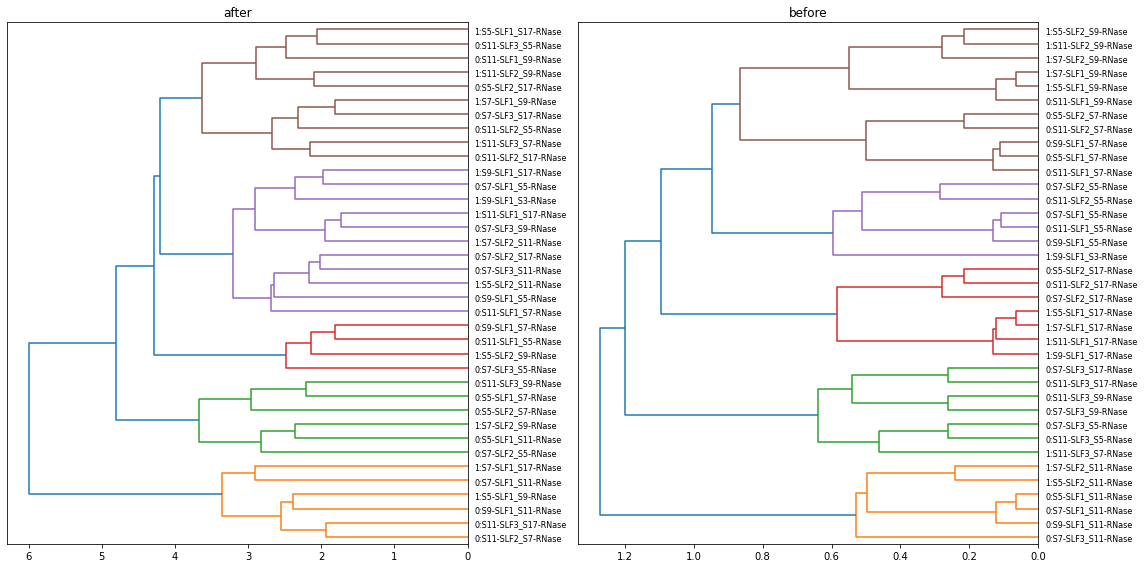

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
plot_dendrogram(model(esm_emb), name_label_dict,ax=ax1)
ax1.set_title("after")
plot_dendrogram(esm_emb, name_label_dict,ax=ax2)
ax2.set_title("before")
fig.tight_layout()

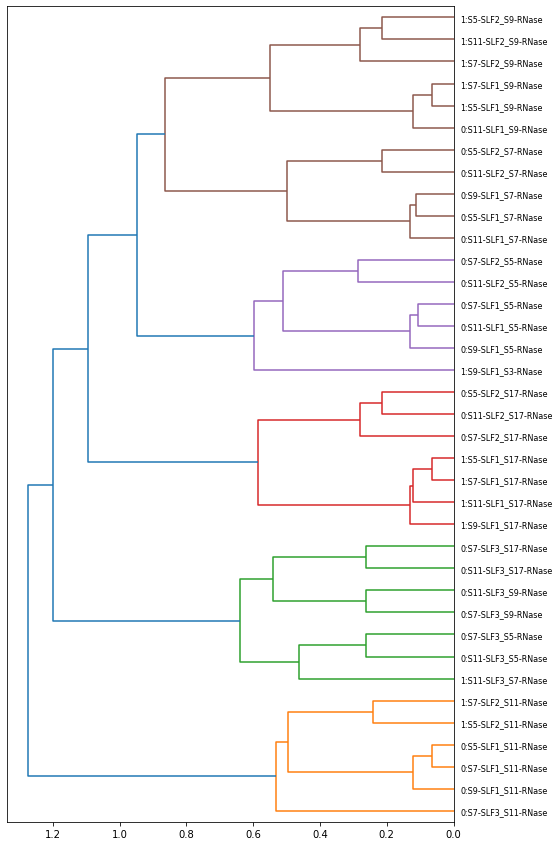

In [24]:
plot_dendrogram(esm_emb, name_label_dict)

In [61]:
dist_map = get_dist_map(label_name_dict, esm_emb, device, dtype,model=model)


In [62]:
pd.DataFrame(dist_map)

,S11-SLF1_S7-RNase,S11-SLF2_S17-RNase,S9-SLF1_S5-RNase,S11-SLF2_S5-RNase,S11-SLF1_S5-RNase,S5-SLF1_S7-RNase,S9-SLF1_S7-RNase,S11-SLF1_S9-RNase,S11-SLF2_S7-RNase,S11-SLF3_S17-RNase,...,S5-SLF1_S9-RNase,S7-SLF1_S9-RNase,S11-SLF3_S7-RNase,S7-SLF1_S17-RNase,S5-SLF2_S11-RNase,S7-SLF2_S9-RNase,S9-SLF1_S17-RNase,S5-SLF2_S9-RNase,S7-SLF2_S11-RNase,S5-SLF1_S17-RNase
S11-SLF1_S7-RNase,0.000000,2.514045,2.193159,2.437975,2.345008,2.605151,2.071667,1.883292,2.566492,2.832028,...,2.558566,2.640115,2.142949,2.331975,2.741490,2.807001,2.172114,3.086341,2.000402,2.151220
S11-SLF2_S17-RNase,2.514045,0.000000,2.681086,3.163424,2.545883,2.845985,2.753005,2.766277,3.047834,3.067775,...,2.992631,2.676751,2.718498,3.256184,2.696799,3.259462,3.351339,3.552437,2.811065,2.437747
S9-SLF1_S5-RNase,2.193159,2.681086,0.000000,2.674241,1.951949,2.617671,2.215054,2.180248,2.233243,2.804567,...,2.766289,2.299617,2.322323,2.454994,2.808157,2.560963,2.816282,3.226085,2.324055,2.320374
S11-SLF2_S5-RNase,2.437975,3.163424,2.674241,0.000000,2.730005,2.891376,2.360265,2.217781,2.908146,2.690379,...,3.028678,3.150356,2.570192,2.286292,3.269577,2.806489,2.371303,3.098288,2.844255,2.292063
S11-SLF1_S5-RNase,2.345008,2.545883,1.951949,2.730005,0.000000,2.631274,1.902189,2.319619,2.544269,3.039886,...,2.600749,2.349022,2.182590,2.607218,2.928563,2.802402,2.784793,2.876728,2.635044,2.190056
S5-SLF1_S7-RNase,2.605151,2.845985,2.617671,2.891376,2.631274,0.000000,2.368635,2.501523,2.749576,3.165760,...,2.334188,2.805267,2.275831,2.697007,3.334500,2.575512,3.059392,2.804526,2.374067,2.253216
S9-SLF1_S7-RNase,2.071667,2.753005,2.215054,2.360265,1.902189,2.368635,0.000000,2.177174,2.749274,2.969397,...,2.546597,2.876410,1.813809,2.384296,2.919392,2.863113,2.520850,2.666725,2.314305,1.726300
S11-SLF1_S9-RNase,1.883292,2.766277,2.180248,2.217781,2.319619,2.501523,2.177174,0.000000,2.399135,2.797905,...,2.403986,2.399912,2.217256,1.812761,3.025080,2.564219,2.195144,2.989226,2.484977,1.959535
S11-SLF2_S7-RNase,2.566492,3.047834,2.233243,2.908146,2.544269,2.749576,2.749274,2.399135,0.000000,2.886841,...,2.935075,2.636434,2.753126,2.746886,3.224259,2.426418,2.442897,3.253018,2.660894,2.631595
S11-SLF3_S17-RNase,2.832028,3.067775,2.804567,2.690379,3.039886,3.165760,2.969397,2.797905,2.886841,0.000000,...,3.234217,2.997487,2.823125,3.170104,2.996458,3.212474,3.044838,3.838152,2.746053,2.774913


In [60]:
pd.DataFrame(pickle.load(open('../data/distance_map/' + \
    dataname + '.pkl', 'rb')) )

,S11-SLF1_S7-RNase,S11-SLF2_S17-RNase,S9-SLF1_S5-RNase,S11-SLF2_S5-RNase,S11-SLF1_S5-RNase,S5-SLF1_S7-RNase,S9-SLF1_S7-RNase,S11-SLF1_S9-RNase,S11-SLF2_S7-RNase,S11-SLF3_S17-RNase,...,S5-SLF1_S9-RNase,S7-SLF1_S9-RNase,S11-SLF3_S7-RNase,S7-SLF1_S17-RNase,S5-SLF2_S11-RNase,S7-SLF2_S9-RNase,S9-SLF1_S17-RNase,S5-SLF2_S9-RNase,S7-SLF2_S11-RNase,S5-SLF1_S17-RNase
S11-SLF1_S7-RNase,0.000000,0.594826,0.421496,0.554301,0.401848,0.114098,0.136997,0.371471,0.366567,0.600573,...,0.395610,0.399946,0.417763,0.434932,0.521540,0.484807,0.455715,0.493239,0.502369,0.441091
S11-SLF2_S17-RNase,0.594826,0.000000,0.593445,0.458530,0.608693,0.595367,0.581446,0.598246,0.426807,0.429932,...,0.603357,0.617001,0.632686,0.377093,0.584938,0.520125,0.354086,0.482661,0.606909,0.366597
S9-SLF1_S5-RNase,0.421496,0.593445,0.000000,0.354086,0.136997,0.413947,0.401848,0.424080,0.522370,0.593222,...,0.423125,0.418884,0.553074,0.447593,0.501298,0.549300,0.458530,0.501593,0.538564,0.461254
S11-SLF2_S5-RNase,0.554301,0.458530,0.354086,0.000000,0.366567,0.554297,0.548494,0.598821,0.401847,0.613195,...,0.603390,0.607041,0.600438,0.560075,0.469001,0.548487,0.564868,0.505939,0.503431,0.564012
S11-SLF1_S5-RNase,0.401848,0.608693,0.136997,0.366567,0.000000,0.417700,0.427598,0.416018,0.533344,0.625763,...,0.437676,0.432005,0.582076,0.456994,0.509256,0.542403,0.488214,0.523079,0.518216,0.471827
S5-SLF1_S7-RNase,0.114098,0.595367,0.413947,0.554297,0.417700,0.000000,0.111750,0.381459,0.366597,0.577979,...,0.371471,0.383781,0.383766,0.427336,0.519024,0.471306,0.449463,0.480033,0.499701,0.426807
S9-SLF1_S7-RNase,0.136997,0.581446,0.401848,0.548494,0.427598,0.111750,0.000000,0.383868,0.354086,0.568870,...,0.382848,0.389080,0.379731,0.428081,0.516287,0.495135,0.426807,0.473138,0.525803,0.432767
S11-SLF1_S9-RNase,0.371471,0.598246,0.424080,0.598821,0.416018,0.381459,0.383868,0.000000,0.558667,0.592271,...,0.114098,0.107109,0.581619,0.378161,0.577088,0.355690,0.403243,0.338695,0.577449,0.391659
S11-SLF2_S7-RNase,0.366567,0.426807,0.522370,0.401847,0.533344,0.366597,0.354086,0.558667,0.000000,0.577685,...,0.563586,0.574830,0.429932,0.531610,0.470347,0.479874,0.526309,0.462872,0.475259,0.527876
S11-SLF3_S17-RNase,0.600573,0.429932,0.593222,0.613195,0.625763,0.577979,0.568870,0.592271,0.577685,0.000000,...,0.574155,0.587495,0.426807,0.392336,0.654848,0.608954,0.379731,0.564871,0.684974,0.383767


In [2]:
for i in tqdm( range(100)):
    print(i)

100%|██████████| 100/100 [00:00<00:00, 88171.20it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
